# VQE with Qiskit

This is the current version of my VQE. Ideally this should not be in a Jupyter notebook, of course. But this form is convenient to play with the different parts of the Qiskit's infrastructure and see how they work.

In [1]:
from qiskit import *
import qiskit.tools.jupyter
import numpy as np
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [2]:
from qiskit.aqua.components.variational_forms import VariationalForm
from qiskit.aqua.components.initial_states import Zero, VarFormBased
from qiskit.aqua.operators import MatrixOperator, TPBGroupedWeightedPauliOperator
from qiskit.aqua.operators.op_converter import to_tpb_grouped_weighted_pauli_operator
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.algorithms.adaptive import VQE

In [3]:
from scipy.sparse import *
from scipy import *

## VQE Settings

In [4]:
num_qubits = 2

## Variational Form

In [5]:
num_var_params = 3
var_form_depth = 1
optimal_params = [-0.386244, 0.317799, -0.416888]
initial_params = [0.0, 0.0, 0.0]
var_form_depth2 = 2
initial_params2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [6]:
class SchwingerAnsatz(VariationalForm):
    """ Variational Layer from Martin's Paper """
    
    CONFIGURATION = {
        'name': 'Schwinger Ansatz',
        'description': 'Variational Form for Schwinger VQE',
        'input_schema': {
            '$schema': 'http://json-schema.org/draft-07/schema#',
            'id': 'schwinger_schema',
            'type': 'object',
            'properties': {
                'depth': {
                    'type': 'integer',
                    'default': 3,
                    'minimum': 1
                },
                'entangler_map': {
                    'type': ['array', 'null'],
                    'default': None
                },
                'entanglement_gate': {
                    'type': 'string',
                    'default': 'cx',
                    'enum': ['cx']
                },
            },
            'additionalProperties': False
        },
        'depends': [
            {
                'pluggable_type': 'initial_state',
                'default': {
                    'name': 'ZERO',
                }
            },
        ],
    }
    
    def __init__(self, depth=3, entangler_map=None, initial_state=None):
        """
        Constructor.
        Args:
            depth (int) : number of rotation layers
            entangler_map (list[list]): describe the connectivity of qubits, each list describes
                             [source, target], or None for full entanglement.
                             Note that the order is the list is the order of
                             applying the two-qubit gate.
            initial_state (InitialState): an initial state object
        """
        self.validate(locals())
        super().__init__()
        #_support_parameterized_circuit = True
        # hard-coded, first pass through FIXME
        num_qubits = 2
        num_parameters = 3
        entanglement='full'
        entanglement_gate='cx'
        skip_unentangled_qubits = False
        self._num_qubits = num_qubits 
        self._depth = depth
        if entangler_map is None:
            self._entangler_map = VariationalForm.get_entangler_map(entanglement, num_qubits)
        else:
            self._entangler_map = VariationalForm.validate_entangler_map(entangler_map, num_qubits)
        # determine the entangled qubits
        all_qubits = []
        for src, targ in self._entangler_map:
            all_qubits.extend([src, targ])
        self._entangled_qubits = sorted(list(set(all_qubits)))
        self._initial_state = initial_state
        self._entanglement_gate = entanglement_gate
        self._skip_unentangled_qubits = skip_unentangled_qubits
        # for the first layer
        self._num_parameters = num_parameters
        # for repeated block
        self._num_parameters += num_parameters * (depth-1)
        self._bounds = [(-np.pi, np.pi)] * self._num_parameters
    
    def construct_circuit(self, parameters, q=None):
        """
        Construct the variational form, given its parameters.
        
        Args:
            parameters (numpy.ndarray): circuit parameters
            q (QuantumRegister): Quantum Register for the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit with given `parameters`
            
        Raises:
            ValueError: the number of parameters is incorrect.
        """
        if len(parameters) != self._num_parameters:
            raise ValueError('The number of parameters has to be {}'.format(self._num_parameters))
        
        if q is None:
            q = QuantumRegister(self._num_qubits, name='q')
        if self._initial_state is not None:
            circuit = self._initial_state.construct_circuit('circuit', q)
        else:
            circuit = QuantumCircuit(q)
        #
        param_idx = 0
        
        def angle(theta=0., phi=0., lam=0.):
            return [theta, phi, lam]

        for _ in range(self._depth):
            # get variational parameters for this layer
            t0 = parameters[param_idx] # theta-angle values
            t1 = parameters[param_idx+1]
            t2 = parameters[param_idx+2]
            t = [angle(t_i) for t_i in [t0, t1, t2]]
            # Construct circuit
            circuit.u3(*(t[1]), 0)  # u3(*angles, q)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[0]), 1)
            circuit.cx(0, 1)        # entangling qubit cx(ctrl, tgt)
            circuit.u3(*(t[2]), 1)
            circuit.barrier(q)

        return circuit  

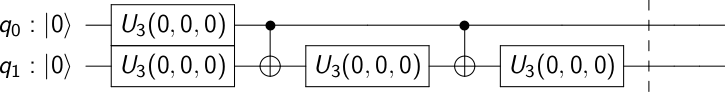

In [7]:
schwinger_form = SchwingerAnsatz(var_form_depth)
vqs_circ = schwinger_form.construct_circuit(initial_params)
vqs_circ.draw(output='latex', scale=0.5)

## Initial State

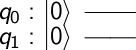

In [8]:
fiducial_state = Zero(num_qubits)
fid_circ = fiducial_state.construct_circuit()
fid_circ.draw(output='latex', scale=0.5)

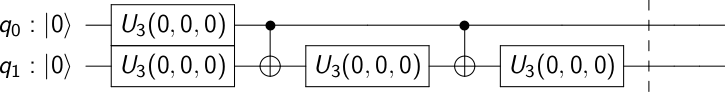

In [9]:
var_form_wavefunction = VarFormBased(schwinger_form, initial_params)
var_form_wavefunction.construct_circuit().draw(output='latex', scale=0.5)

## Hamiltonian

In [1]:
# these correspond to L=2 spatial sites. 
# They have slightly different truncations so that the dimensions of the matrices are the same.

h_even = np.array([
 [-0.20036, 1.19976, 0., 0.],
 [1.19976, 1., 0.848358, 0.],
 [0., 0.848358, 2.20036, 0.848358],
 [0., 0., 0.848358, 3.]
])

h_odd = np.array([
    [1., 0.848358, 0., 0.],
    [0.848358, 2.20036, -0.848358, 0.],
    [0., -0.848358, 3., -0.848358],
    [0., 0., -0.848358, 3.79964]
])

NameError: name 'np' is not defined

In [30]:
# this is a "switch" :)
h = h_even
# h = h_odd

In [66]:
# Thread on qubit ordering in Qiskit
# https://github.com/Qiskit/qiskit-terra/issues/1148

In [31]:
H_mat = csr_matrix(h)
H_MatrixOperator = MatrixOperator(H_mat)
H_Operator = to_tpb_grouped_weighted_pauli_operator(H_MatrixOperator, 
                                                    TPBGroupedWeightedPauliOperator.sorted_grouping)
print(H_Operator.print_details())

TPB: YY (2)
II	(1.5+0j)
YY	(0.424179+0j)
TPB: XX (2)
IX	(1.0240589999999998+0j)
XX	(0.424179+0j)
TPB: ZZ (3)
IZ	(-0.5+0j)
ZI	(-1.10018+0j)
ZZ	(-0.10017999999999999+0j)
TPB: ZX (1)
ZX	(0.175701+0j)



In [32]:
operator_mode=None
input_circuit=None
backend=None
qr=None
cr=None
use_simulator_operator_mode=False
wave_function=fid_circ
statevector_mode=True

In [33]:
H_circs = H_Operator.construct_evaluation_circuit(operator_mode,
                                        input_circuit,
                                        backend,
                                        qr,
                                        cr,
                                        use_simulator_operator_mode,
                                        wave_function,
                                        statevector_mode)

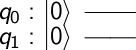

In [34]:
H_circs[0].draw(output='latex', scale=0.5)

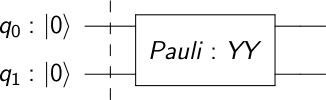

In [35]:
H_circs[1].draw(output='latex', scale=0.5)

## Optimizer

In [36]:
max_trials = 500
optimizer = qiskit.aqua.components.optimizers.SPSA(max_trials)
print(optimizer.setting) 

Optimizer: SPSA
-- gradient_support_level: 1
-- bounds_support_level: 1
-- initial_point_support_level: 3
-- options: {'last_avg': 1, 'save_steps': 1}
-- max_evals_grouped: 1
-- max_trials: 500
-- parameters: [0.62831853 0.1        0.602      0.101      0.        ]
-- skip_calibration: False



## Variational Quantum Simulation
### Extend VQE class to incude statistics in results, or find a way to retrieve statistics from the existing class

Q: where is the counts object in the existing class?

In [37]:
# a callback that can access the intermediate data 
# during the optimization.
# Internally, four arguments are provided as follows 
# the index of evaluation, parameters of variational form,
# evaluated mean, evaluated standard deviation.
def simple_callback(eval_count, parameter_set, mean, std):
    if eval_count % 1 == 0:
        print('Energy evaluation %s returned %4f +/- %4f' % (eval_count, np.real(mean), np.real(std)))

In [38]:
# classVQE(operator, var_form, optimizer, 
# operator_mode=None, initial_point=None, 
# max_evals_grouped=1, 
# aux_operators=None, callback=None, 
# auto_conversion=True)
operator_mode = None
initial_point = initial_params
max_evals_grouped=1              # max number of evaluations performed simultaneously
aux_operators = None
auto_conversion=False
sim = VQE(H_Operator, schwinger_form, optimizer,
          operator_mode,
          initial_point, 
          max_evals_grouped, 
          aux_operators, 
          simple_callback, 
          auto_conversion)

In [39]:
backend = None
use_simulator_operator_mode=False
statevector_mode=True

In [40]:
sim_circs = sim.construct_circuit(initial_params, backend, use_simulator_operator_mode, statevector_mode)

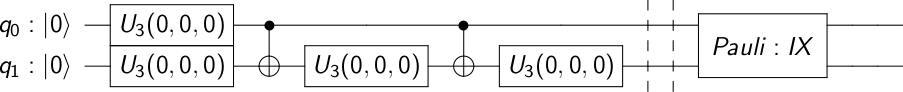

In [41]:
sim_circs[2].draw(output='latex', scale=0.5)

In [42]:
backend_sim = Aer.get_backend('qasm_simulator')

In [43]:
from qiskit.aqua import QuantumInstance
nshots = 1024
my_quantum_instance = QuantumInstance(backend_sim, nshots)

In [44]:
print(my_quantum_instance)


Qiskit Terra version: 0.10.0
Backend: 'qasm_simulator (AerProvider)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'cz', 'cu1', 'id', 'x', 'y', 'z', 'h', 's', 'sdg', 't', 'tdg', 'ccx', 'swap', 'multiplexer', 'snapshot', 'unitary', 'reset', 'initialize', 'kraus', 'roerror'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None


In [45]:
print(sim.print_settings())


==================== Setting of VQE ============================
Algorithm: VQE
-- quantum_instance: None
-- var_form: <__main__.SchwingerAnsatz object at 0x120fcb908>
-- optimizer: <qiskit.aqua.components.optimizers.spsa.SPSA object at 0x12189b400>
-- cost_fn: <bound method VQE._energy_evaluation of <qiskit.aqua.algorithms.adaptive.vqe.vqe.VQE object at 0x122da8c88>>
-- initial_point: [0.0, 0.0, 0.0]
-- callback: <function simple_callback at 0x121906048>
-- operator: : Representation: tpb grouped paulis, qubits: 2, size: 8, group: 4
-- eval_count: 0
-- aux_operators: []
-- auto_conversion: False
Variational Form: Schwinger Ansatz
-- num_parameters: 3
-- num_qubits: 2
-- bounds: [(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793)]
-- depth: 1
-- entangler_map: [[0, 1]]
-- entangled_qubits: [0, 1]
-- initial_state: None
-- entanglement_gate: cx
-- skip_unentangled_qubits: False
Optimizer: SPSA
-- gradient_support_le

In [46]:
res = sim.run(my_quantum_instance)

Energy evaluation 1 returned -0.312960 +/- 0.039092
Energy evaluation 2 returned -0.101098 +/- 0.037014
Energy evaluation 3 returned -0.043640 +/- 0.036914
Energy evaluation 4 returned -0.359775 +/- 0.038585
Energy evaluation 5 returned -0.081191 +/- 0.038695
Energy evaluation 6 returned -0.348835 +/- 0.035769
Energy evaluation 7 returned -0.307141 +/- 0.038924
Energy evaluation 8 returned -0.093443 +/- 0.035949
Energy evaluation 9 returned -0.002269 +/- 0.036172
Energy evaluation 10 returned -0.235246 +/- 0.042387
Energy evaluation 11 returned -0.256707 +/- 0.041350
Energy evaluation 12 returned -0.078893 +/- 0.035675
Energy evaluation 13 returned -0.275174 +/- 0.038760
Energy evaluation 14 returned -0.033440 +/- 0.036243
Energy evaluation 15 returned -0.231284 +/- 0.036018
Energy evaluation 16 returned 0.039395 +/- 0.041877
Energy evaluation 17 returned -0.287118 +/- 0.041816
Energy evaluation 18 returned -0.022548 +/- 0.035968
Energy evaluation 19 returned -0.372349 +/- 0.038444
Ene

Energy evaluation 156 returned -0.977754 +/- 0.030779
Energy evaluation 157 returned -0.972822 +/- 0.033547
Energy evaluation 158 returned -0.989923 +/- 0.031149
Energy evaluation 159 returned -0.977630 +/- 0.030004
Energy evaluation 160 returned -0.966276 +/- 0.036104
Energy evaluation 161 returned -1.032474 +/- 0.032505
Energy evaluation 162 returned -0.995728 +/- 0.032235
Energy evaluation 163 returned -0.978751 +/- 0.031491
Energy evaluation 164 returned -0.928298 +/- 0.034838
Energy evaluation 165 returned -0.951703 +/- 0.036331
Energy evaluation 166 returned -0.964104 +/- 0.028656
Energy evaluation 167 returned -0.994273 +/- 0.031479
Energy evaluation 168 returned -1.013213 +/- 0.031778
Energy evaluation 169 returned -0.958846 +/- 0.030172
Energy evaluation 170 returned -0.997140 +/- 0.034054
Energy evaluation 171 returned -0.971058 +/- 0.031765
Energy evaluation 172 returned -0.984947 +/- 0.033022
Energy evaluation 173 returned -0.944092 +/- 0.030647
Energy evaluation 174 return

Energy evaluation 308 returned -0.982960 +/- 0.032953
Energy evaluation 309 returned -1.016643 +/- 0.030054
Energy evaluation 310 returned -0.957738 +/- 0.034455
Energy evaluation 311 returned -1.010879 +/- 0.029988
Energy evaluation 312 returned -0.981442 +/- 0.034315
Energy evaluation 313 returned -1.008678 +/- 0.029064
Energy evaluation 314 returned -0.924320 +/- 0.035833
Energy evaluation 315 returned -1.017333 +/- 0.028538
Energy evaluation 316 returned -1.005444 +/- 0.033763
Energy evaluation 317 returned -0.982334 +/- 0.028658
Energy evaluation 318 returned -0.964909 +/- 0.034040
Energy evaluation 319 returned -0.966101 +/- 0.034301
Energy evaluation 320 returned -0.939906 +/- 0.028442
Energy evaluation 321 returned -0.968772 +/- 0.029772
Energy evaluation 322 returned -1.046850 +/- 0.030765
Energy evaluation 323 returned -0.984982 +/- 0.032787
Energy evaluation 324 returned -0.990503 +/- 0.029865
Energy evaluation 325 returned -1.017764 +/- 0.028752
Energy evaluation 326 return

Energy evaluation 460 returned -0.998995 +/- 0.031430
Energy evaluation 461 returned -0.997782 +/- 0.033850
Energy evaluation 462 returned -1.005171 +/- 0.029771
Energy evaluation 463 returned -1.044870 +/- 0.030491
Energy evaluation 464 returned -1.089435 +/- 0.030343
Energy evaluation 465 returned -1.017014 +/- 0.028469
Energy evaluation 466 returned -0.949915 +/- 0.034741
Energy evaluation 467 returned -0.988227 +/- 0.029346
Energy evaluation 468 returned -0.970201 +/- 0.033249
Energy evaluation 469 returned -1.041182 +/- 0.028652
Energy evaluation 470 returned -1.006448 +/- 0.033239
Energy evaluation 471 returned -1.000450 +/- 0.030018
Energy evaluation 472 returned -0.982792 +/- 0.032452
Energy evaluation 473 returned -1.005076 +/- 0.029224
Energy evaluation 474 returned -0.996627 +/- 0.031898
Energy evaluation 475 returned -1.058459 +/- 0.031425
Energy evaluation 476 returned -1.004578 +/- 0.028678
Energy evaluation 477 returned -0.992924 +/- 0.032056
Energy evaluation 478 return

Energy evaluation 612 returned -1.060558 +/- 0.030551
Energy evaluation 613 returned -0.930496 +/- 0.035381
Energy evaluation 614 returned -0.924492 +/- 0.029831
Energy evaluation 615 returned -0.981252 +/- 0.034111
Energy evaluation 616 returned -1.012124 +/- 0.029448
Energy evaluation 617 returned -1.022328 +/- 0.034233
Energy evaluation 618 returned -1.037974 +/- 0.028247
Energy evaluation 619 returned -1.005443 +/- 0.028544
Energy evaluation 620 returned -1.055727 +/- 0.032564
Energy evaluation 621 returned -0.974949 +/- 0.032197
Energy evaluation 622 returned -0.985693 +/- 0.032088
Energy evaluation 623 returned -0.997293 +/- 0.032324
Energy evaluation 624 returned -0.984620 +/- 0.030627
Energy evaluation 625 returned -0.897118 +/- 0.034828
Energy evaluation 626 returned -0.966810 +/- 0.030937
Energy evaluation 627 returned -0.949687 +/- 0.032211
Energy evaluation 628 returned -1.003103 +/- 0.030951
Energy evaluation 629 returned -1.061392 +/- 0.028990
Energy evaluation 630 return

Energy evaluation 764 returned -0.984406 +/- 0.028709
Energy evaluation 765 returned -1.038847 +/- 0.028800
Energy evaluation 766 returned -0.945290 +/- 0.035992
Energy evaluation 767 returned -0.934604 +/- 0.030318
Energy evaluation 768 returned -1.025080 +/- 0.033580
Energy evaluation 769 returned -1.001754 +/- 0.031031
Energy evaluation 770 returned -0.969815 +/- 0.034262
Energy evaluation 771 returned -1.032264 +/- 0.028857
Energy evaluation 772 returned -0.965925 +/- 0.034774
Energy evaluation 773 returned -0.955554 +/- 0.030673
Energy evaluation 774 returned -1.006333 +/- 0.033086
Energy evaluation 775 returned -1.019836 +/- 0.034222
Energy evaluation 776 returned -0.993095 +/- 0.029411
Energy evaluation 777 returned -0.995085 +/- 0.030918
Energy evaluation 778 returned -0.972708 +/- 0.033856
Energy evaluation 779 returned -1.006356 +/- 0.033156
Energy evaluation 780 returned -0.983738 +/- 0.031730
Energy evaluation 781 returned -0.999202 +/- 0.032426
Energy evaluation 782 return

Energy evaluation 916 returned -1.027552 +/- 0.029684
Energy evaluation 917 returned -1.038957 +/- 0.031342
Energy evaluation 918 returned -1.032703 +/- 0.030499
Energy evaluation 919 returned -1.012438 +/- 0.031287
Energy evaluation 920 returned -0.954840 +/- 0.032072
Energy evaluation 921 returned -0.941036 +/- 0.031047
Energy evaluation 922 returned -0.978787 +/- 0.032874
Energy evaluation 923 returned -1.023992 +/- 0.031888
Energy evaluation 924 returned -1.051470 +/- 0.030525
Energy evaluation 925 returned -0.953305 +/- 0.032180
Energy evaluation 926 returned -1.027486 +/- 0.031497
Energy evaluation 927 returned -1.012056 +/- 0.030152
Energy evaluation 928 returned -1.005287 +/- 0.032828
Energy evaluation 929 returned -0.958502 +/- 0.034190
Energy evaluation 930 returned -1.005403 +/- 0.029471
Energy evaluation 931 returned -0.951173 +/- 0.030098
Energy evaluation 932 returned -0.983252 +/- 0.031644
Energy evaluation 933 returned -1.014983 +/- 0.031564
Energy evaluation 934 return

In [47]:
res

{'num_optimizer_evals': None,
 'min_val': -1.0310529453124997,
 'opt_params': array([ 0.13028114, -1.18048464,  0.17737505]),
 'eval_time': 319.48160219192505,
 'eval_count': 1051,
 'energy': -1.0310529453124997,
 'eigvals': array([-1.03105295]),
 'min_vector': {'00': 679, '10': 35, '01': 306, '11': 4},
 'eigvecs': array([{'00': 679, '10': 35, '01': 306, '11': 4}], dtype=object)}

In [48]:
sim.get_optimal_vector()

{'00': 669, '10': 39, '01': 311, '11': 5}

In [40]:
sim.get_optimal_cost()

-1.0123023945312497

In [41]:
energy_eval = sim.get_optimal_cost()

In [42]:
energy_eval_err = 0.011

In [43]:
sim._ret['opt_params']

array([ 0.16592805, -1.17523697,  0.09040933])

In [44]:
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])
sim._energy_evaluation(sim._ret['opt_params'])

Energy evaluation 1052 returned -1.026434 +/- 0.032051
Energy evaluation 1053 returned -1.038314 +/- 0.031294
Energy evaluation 1054 returned -0.969552 +/- 0.033326
Energy evaluation 1055 returned -1.061718 +/- 0.031637
Energy evaluation 1056 returned -0.998336 +/- 0.031866


-0.9983360878906249

In [45]:
sim.quantum_instance.backend

<QasmSimulator('qasm_simulator') from AerProvider()>

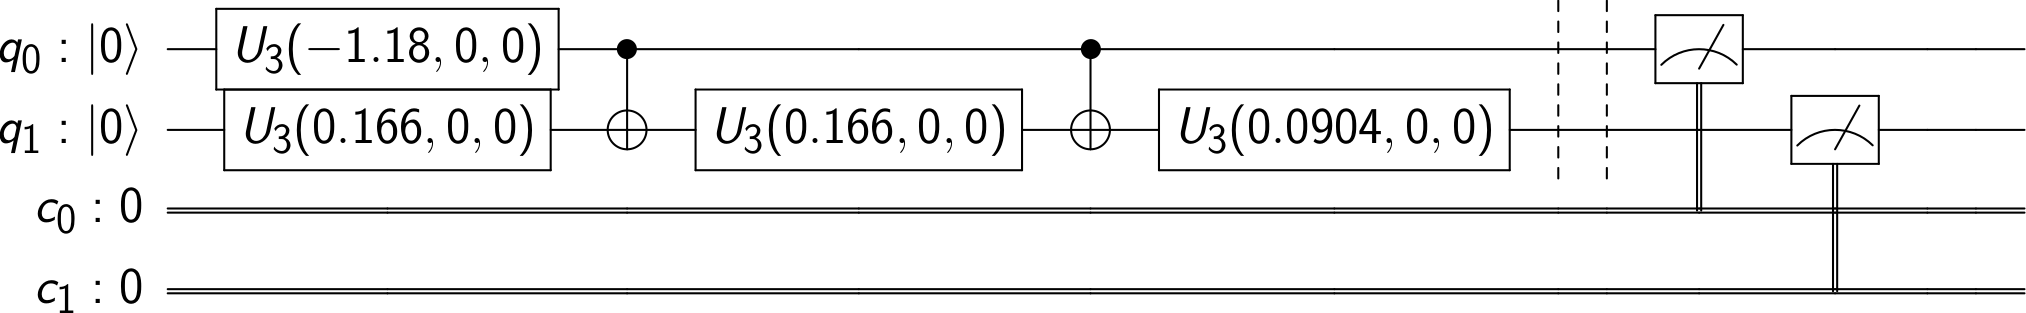

In [52]:
from qiskit.aqua.utils.run_circuits import find_regs_by_name
opt_circ = sim.get_optimal_circuit()
c = ClassicalRegister(opt_circ.width(), name='c')
q = find_regs_by_name(opt_circ, 'q')
opt_circ.add_register(c)
opt_circ.barrier(q)
opt_circ.measure(q, c)
opt_circ.draw(output='latex', filename='example_gate.png', scale=1.0)

In [55]:
latex_source = opt_circ.draw(output='latex_source', filename='example_gate.png', scale=0.5)
print(latex_source)

% \documentclass[preview]{standalone}
% If the image is too large to fit on this documentclass use
\documentclass[draft]{beamer}
% img_width = 4, img_depth = 12
\usepackage[size=custom,height=10,width=40,scale=0.5]{beamerposter}
% instead and customize the height and width (in cm) to fit.
% Large images may run out of memory quickly.
% To fix this use the LuaLaTeX compiler, which dynamically
% allocates memory.
\usepackage[braket, qm]{qcircuit}
\usepackage{amsmath}
\pdfmapfile{+sansmathaccent.map}
% \usepackage[landscape]{geometry}
% Comment out the above line if using the beamer documentclass.
\begin{document}
\begin{equation*}
    \Qcircuit @C=1.0em @R=0.0em @!R {
	 	\lstick{ q_{0} : \ket{0} } & \gate{U_3(-1.18,0,0)} & \ctrl{1} & \qw & \ctrl{1} & \qw \barrier[0em]{1} & \qw \barrier[0em]{1} & \qw & \meter & \qw & \qw & \qw & \qw\\
	 	\lstick{ q_{1} : \ket{0} } & \gate{U_3(0.166,0,0)} & \targ & \gate{U_3(0.166,0,0)} & \targ & \gate{U_3(0.0904,0,0)} & \qw & \qw & \qw & \meter & \qw & \q

In [36]:
# build an optimized circuit;
# make measurement, retrieve memory
# bootstrap uncertainties

In [37]:
sim.quantum_instance.run_config.shots

1024

In [38]:
sim.quantum_instance.set_config(shots=1024, memory=True)

In [39]:
sim.quantum_instance.run_config

RunConfig(max_credits=10, memory=True, shots=1024)

In [99]:
# takes in results from a single circuit 
# with memory=True, and estimates
# the uncertanities on the probability of each outcome 
# (currently with bootstrap)
# returns outcome:(pba, std) dictionary
def compute_stats(res, invert_qubit_order = False):
    # check that there is a single circuit in the results
    # (ambiguous otherwise)
    assert(len(res.results)==1)
    # generates all possible outcomes given \
    # the number of qubits 
    def _generate_bitstrings(nqubits, invert_qubit_order):
        # (recursive, modifies all_strings in place)
        def _generate_bitstrings_rec(nqubits, all_strings, a_string, irecur): 
            # base
            if irecur == nqubits: 
                all_strings.append(''.join([bit for bit in a_string]))
                return 
            # append 0
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['0'], irecur + 1)
            # append 1
            _generate_bitstrings_rec(nqubits, all_strings, a_string + ['1'], irecur + 1)
        all_strings = []
        _generate_bitstrings_rec(nqubits, all_strings, [], 0)
        if (invert_qubit_order): 
        # pesky Qiskit messes up qubit ordering... this may or may not be necessary to translate the results.
            all_strings = [''.join(reversed(bitstring)) for bitstring in all_strings]
        return all_strings
    # bootstrap specific?
    # given ensembles of outcomes and a particular outcome
    # calculates the statistics of that outcome:
    # returns outcome:(pba, std) estimates for the outcome
    def _calc_outcome_stats(ensembles, nshots, outcome):
        cts = np.count_nonzero(ensembles==outcome, axis=0)
        pba = np.mean(cts)/nshots
        std = np.std(cts/nshots, ddof = 1) # use unbiased estimator
        return (pba, std)
    nqubits = int(np.log2(len(res.get_counts(0)))) # pull number of qubits from results
    outcomes = _generate_bitstrings(nqubits, invert_qubit_order)
    mem = res.get_memory(0)
    nshots = sum(list(res.get_counts(0).values()))
    nens = nshots # choose number of ensemles = number of samples
    nsam = nshots
    ensembles = np.random.choice(mem, (nens, nsam))
    stats = map(lambda outcome: (outcome, _calc_outcome_stats(ensembles, nshots, outcome)), outcomes)
    return dict(stats)

In [123]:
sim.quantum_instance.set_config(shots=8*1024, memory=True)
opt_res = sim.quantum_instance.execute(opt_circ)
sim.quantum_instance.set_config(shots=8*1024, memory=False) # reset to no memory! saves resources?

In [124]:
measured_coeffs =compute_stats(opt_res)

In [125]:
measured_coeffs

{'00': (0.6633566468954086, 0.0051791707031224),
 '01': (0.31028591096401215, 0.005074526669436938),
 '10': (0.024283871054649353, 0.001710327639293606),
 '11': (0.0020735710859298706, 0.0005048760400780176)}

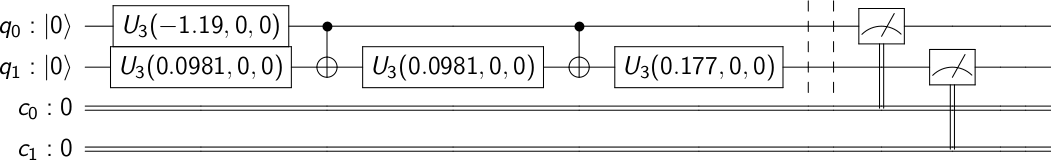

In [126]:
transp_circ = transpile(opt_circ, sim.quantum_instance.backend, optimization_level=3)
transp_circ.draw(output='latex', scale=0.5)

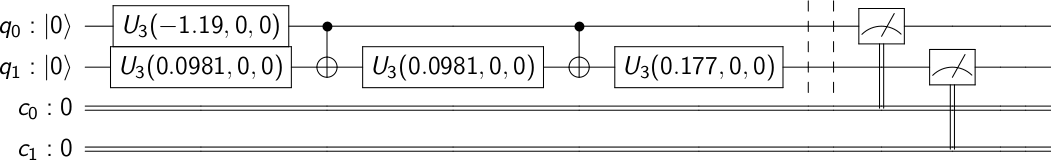

In [45]:
opt_circ.decompose().draw(output='latex', scale=0.5)

In [105]:
# compare with Mathematica's expectations
mathematica_res = -1.01162 # Even
mathematica_res2 = 0.486204 # Odd

# odd coefficients
even_coeffs = [0.669069, 0.305919, 0.023941, 0.00107068]
even_coeffs_at_theta = [0.664109, 0.0236388, 0.309821, 0.00243079]
odd_coeffs = [0.7041621406145364, 0.2582831083289985, 0.03524433188695736, 0.002310419169507747]

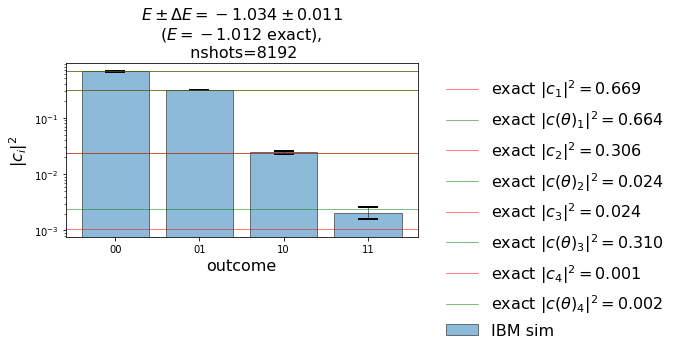

In [129]:
import matplotlib.pyplot as plt
outcomes = list(measured_coeffs.keys())
outcomes_bars = np.arange(len(outcomes))
avgs = [measured_coeffs[outcome][0] for outcome in outcomes]
stds = [measured_coeffs[outcome][1] for outcome in outcomes]
fig, ax = plt.subplots()
ax.bar(outcomes_bars, avgs, yerr=stds, 
       align='center', alpha=0.5, ecolor='black',
       edgecolor='k',
       error_kw=dict(lw=0.5, capsize=10, capthick=2.0),
       label='IBM sim')
ax.set_ylabel(r'$|c_i|^2$', fontsize=16)
ax.set_xlabel(r'outcome', fontsize=16)
ax.set_xticks(outcomes_bars)
ax.set_xticklabels(outcomes)
ax.set_title('$E \\pm \\Delta E = %.3f \\pm %.3f$\n($E = %.3f$ exact),\n nshots=%d' 
             % (energy_eval, energy_eval_err, mathematica_res, 
                sim.quantum_instance.run_config.shots), fontsize=16)
for icoeff in range(len(even_coeffs)):
    ax.axhline(y = even_coeffs[icoeff], color ='red', linewidth = 0.5, 
               label=r'exact $|c_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs[icoeff]))
    ax.axhline(y = even_coeffs_at_theta[icoeff], color ='green', linewidth = 0.5, 
               label=r'exact $|c(\theta)_{%d}|^2 = %.3f$' % (icoeff+1, even_coeffs_at_theta[icoeff]))
ax.set_yscale('log')
plt.tight_layout()
plt.legend(frameon=False, fontsize=16, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.savefig("even.png", dpi=300)